In [1]:
import os
import numpy as np
import xarray as xr
import subprocess
from matplotlib import pyplot as plt

In [2]:
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/LENS2/'
dir_t2 = '/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/'
var_1d = ['TREFMXAV', 'TREFMNAV']
n_var = len(var_1d)

experiment = 'BHIST'
experiment = 'SSP370'
if experiment == 'SSP370':
    year_s = 2015
    year_e = 2095
elif experiment == 'BHIST':
    year_s = 1980
    year_e = 2010

if year_e == 2095:
    ## the last one is 209501-210012 6 years-72 months
    n_month = (year_e - year_s)*12 + 72
    year_ee = year_e + 5
elif year_e == 2010:
    ## the last one is 201001-201412 5 years-60 months
    n_month = (year_e - year_s)*12 + 60
    year_ee = year_e + 4
else:
    year_ee = year_e

yyyymm_1d = np.zeros(n_month, dtype=int)

ct = 0
for year in range(year_s, year_ee + 1):
    for month in range(1, 12 + 1):
        yyyymm_1d[ct] = year*100 + month
        ct = ct + 1
        
flnm_o_1d = []
for nv in range(n_var):
    flnm_o_1d.append(dir_o + var_1d[nv]+ '_monthly_globalAvg_' + str(year_s) + '01-' + str(year_ee) + '12.nc')

#### Creating weights
I use the 2m air_temperature LENS2 dataset to calculate the area-weighted temperature over its domain. This dataset has a regular latitude/ longitude grid, thus the grid cell area decreases towards the pole, using the cosine of the latitude as proxy for the grid cell area. <br>
https://docs.xarray.dev/en/latest/examples/area_weighted_temperature.html#Weighted-mean

In [3]:
if experiment == 'SSP370':
    flnm = '/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.201501-202412.nc'
elif experiment == 'BHIST':
    flnm = '/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BHISTcmip6.f09_g17.LE2-1281.010.clm2.h0.TREFMXAV.195001-195912.nc'
  
with xr.open_dataset(flnm) as ds:
    air = ds[var_1d[0]]
    ## For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
    weights = np.cos(np.deg2rad(air.lat))
    weights.name = "weights"
    
    # weighted mean
    air_weighted = air.weighted(weights)       

In [4]:
if experiment == 'SSP370':
    cmd_ls = 'ls -1 ' + dir_t2 + var_1d[0] + '/b.e21.BSSP370*' + 'h0.TREFMXAV.201501*.nc '
    if year_e == 2095:
        ## the last one is 209501-210012 6 years
        n_month = (year_e - year_s)*12 + 72
    else:
        n_month = (year_e - year_s)*12 + 120
elif experiment == 'BHIST':
    cmd_ls = 'ls -1 ' + dir_t2 + var_1d[0] + '/b.e21.BHIST*.' + 'h0.TREFMXAV.195001*.nc '
    
    if year_e == 2010:
        ## the last one is 201001-201412 5 years-60 months
        n_month = (year_e - year_s)*12 + 60
    else:
        n_month = (year_e - year_s)*12 + 120

print(n_month, ' months in dataset')

# store os.system() output in a variable 
flnm_str = os.popen(cmd_ls).read()

# convert string to list and through out last item which is empty
flnm_li = list(flnm_str.split("\n"))[:-1]
n_mem = len(flnm_li)
print(n_mem, 'members') 

1032  months in dataset
100 members


In [5]:
n_year = int(n_month/12)

t2_3d = np.zeros((n_var, n_mem, n_month))

n_month_dec = 120

nv = 0
for var_s in var_1d:
    if os.path.isfile(flnm_o_1d[nv]):
        print(flnm_o_1d[nv], 'exist')
        with xr.open_dataset(flnm_o_1d[nv]) as ds:
            t2_3d[nv]=ds[var_s]
    else:
        for year in range(year_s, year_e+1, 10):
            # the start index of each file
            ct_st = int((year-year_s)*0.1*n_month_dec)
            if year == year_e and year_e == 2010:
                ct_e = ct_st + 60
            if year == year_e and year_e == 2095:
                ct_e = ct_st + 72
            else:
                ct_e = ct_st + n_month_dec
                
            if experiment == 'BHIST':
                cmd_ls = 'ls -1 ' + dir_t2 + var_1d[nv] + '/b.e21.BHIST*' + 'h0.'+var_1d[nv]+'.' + str(year)+ '01*.nc '
            elif experiment == 'SSP370':
                cmd_ls = 'ls -1 ' + dir_t2 + var_1d[nv] + '/b.e21.BSSP370*' + 'h0.'+var_1d[nv]+'.' + str(year)+ '01*.nc '
        # store os.system() output in a variable 
            #print(cmd_ls)
            # store os.system() output in a variable 
            flnm_str = os.popen(cmd_ls).read()

            # convert string to list and through out last item which is empty
            flnm_li = list(flnm_str.split("\n"))[:-1]
            n_mem_t = len(flnm_li)
            print(flnm_li[0])
        
            if n_mem_t != n_mem:
                print(n_mem_t, '!=', n_mem)
            else:
                for nm in range(n_mem):
                    flnm = flnm_li[nm]
                 
                    with xr.open_dataset(flnm) as ds:
                        t2_weighted = ds[var_s].weighted(weights)
                        weighted_mean = t2_weighted.mean(("lon", "lat"))
                        t2_3d[nv, nm, ct_st:ct_e] = weighted_mean
                        #print(nm, ct_st, ct_e, flnm)
        # # from np array to xarray
        t2_2d_xr = xr.DataArray(t2_3d[nv], 
                        coords={'member': np.arange(1, n_mem+1),'time': yyyymm_1d}, 
                        dims=["member", "time"])
                         

        # create and write out dataset 
        flnm_o = dir_o + var_1d[nv]+ '_monthly_globalAvg_' + str(year_s) + '01-' + str(year_ee) + '12.nc'
        print(flnm_o)
        ds = t2_2d_xr.to_dataset(name = var_1d[nv])
        ds.attrs['script'] = 'Ming Ge: t2_ts_lens2.ipynb'
        ds.to_netcdf(flnm_o)
    
    nv = nv + 1                 


/glade/campaign/mmm/c3we/mingge/DOD/LENS2/TREFMXAV_monthly_globalAvg_201501-210012.nc exist
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/TREFMNAV_monthly_globalAvg_201501-210012.nc exist


#### PLOTTING

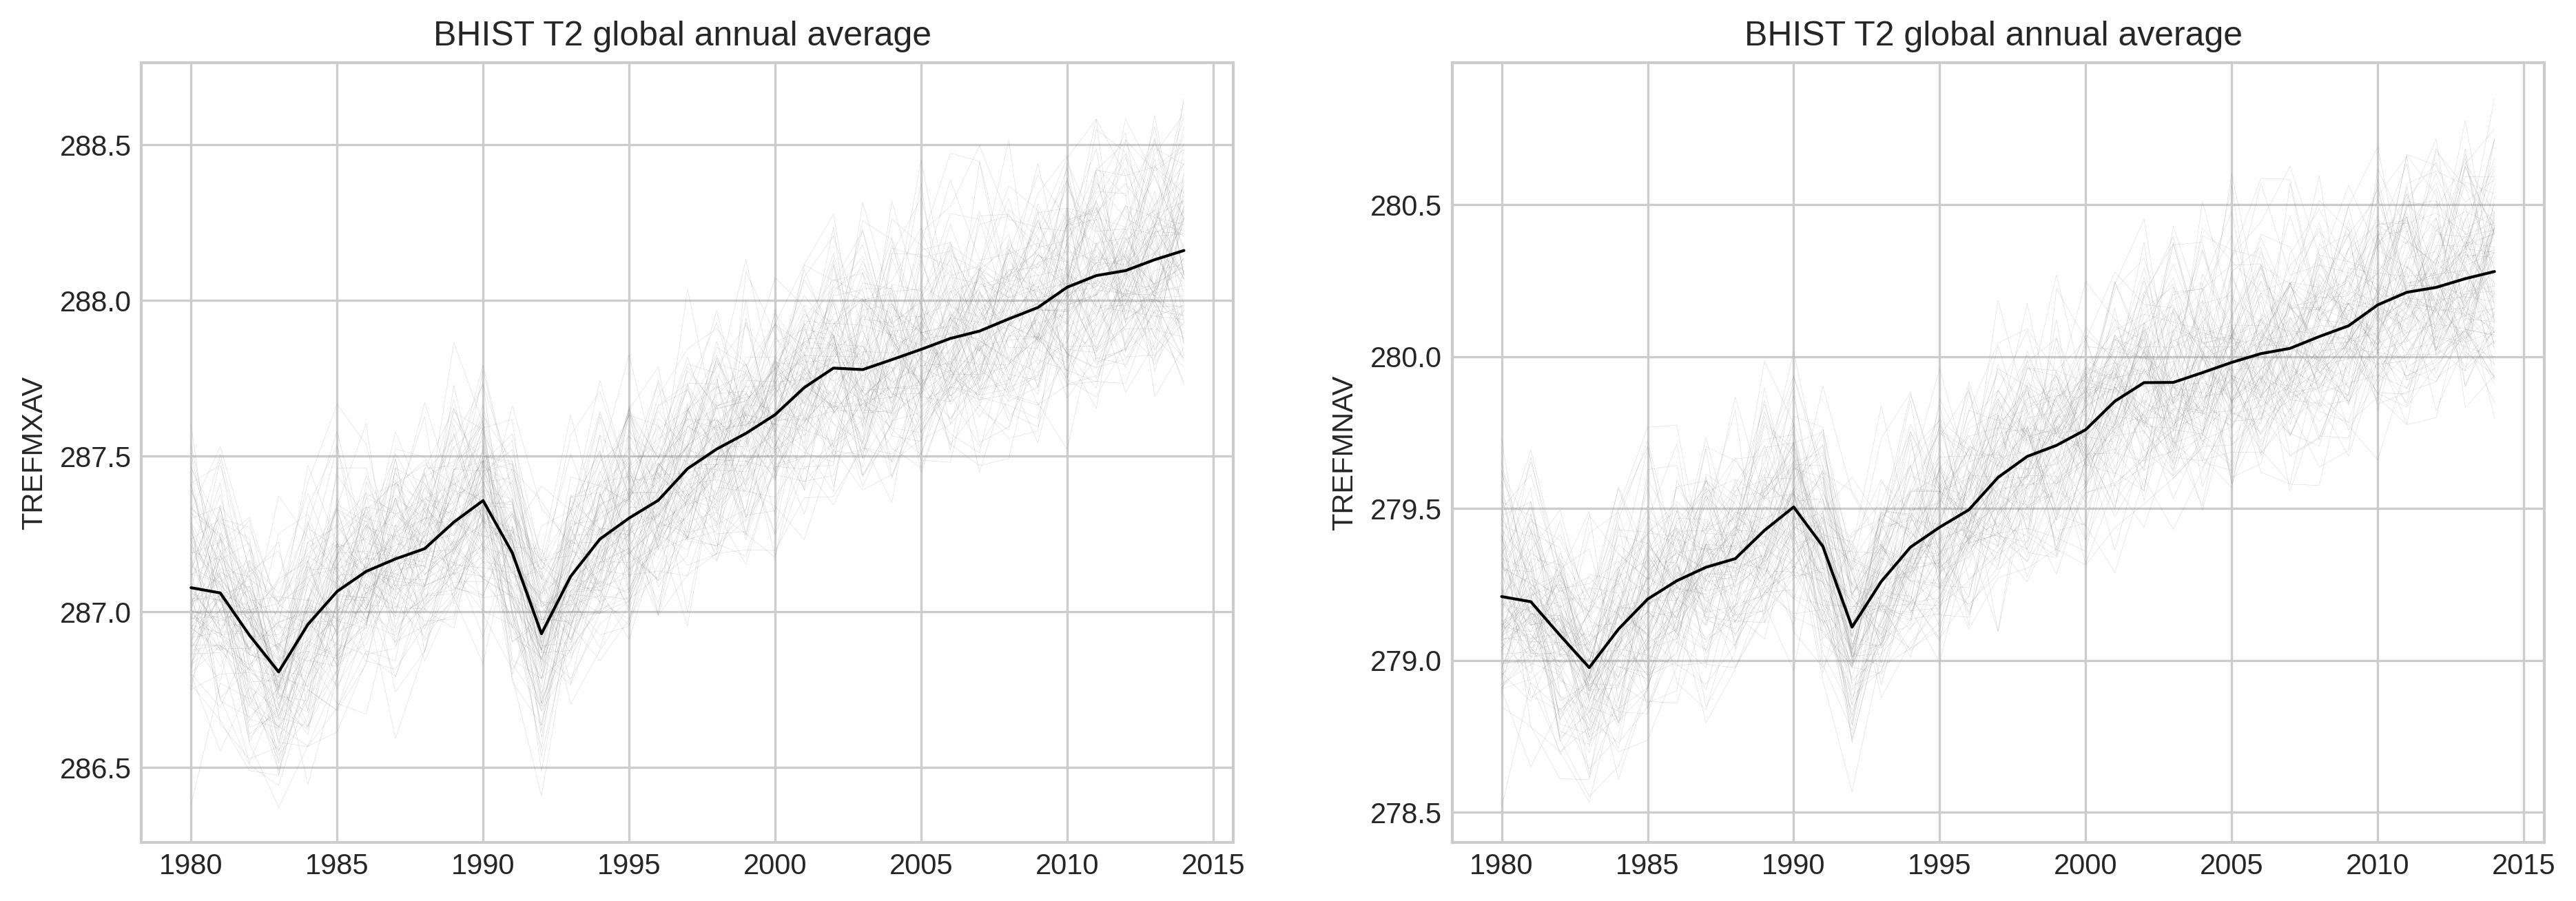

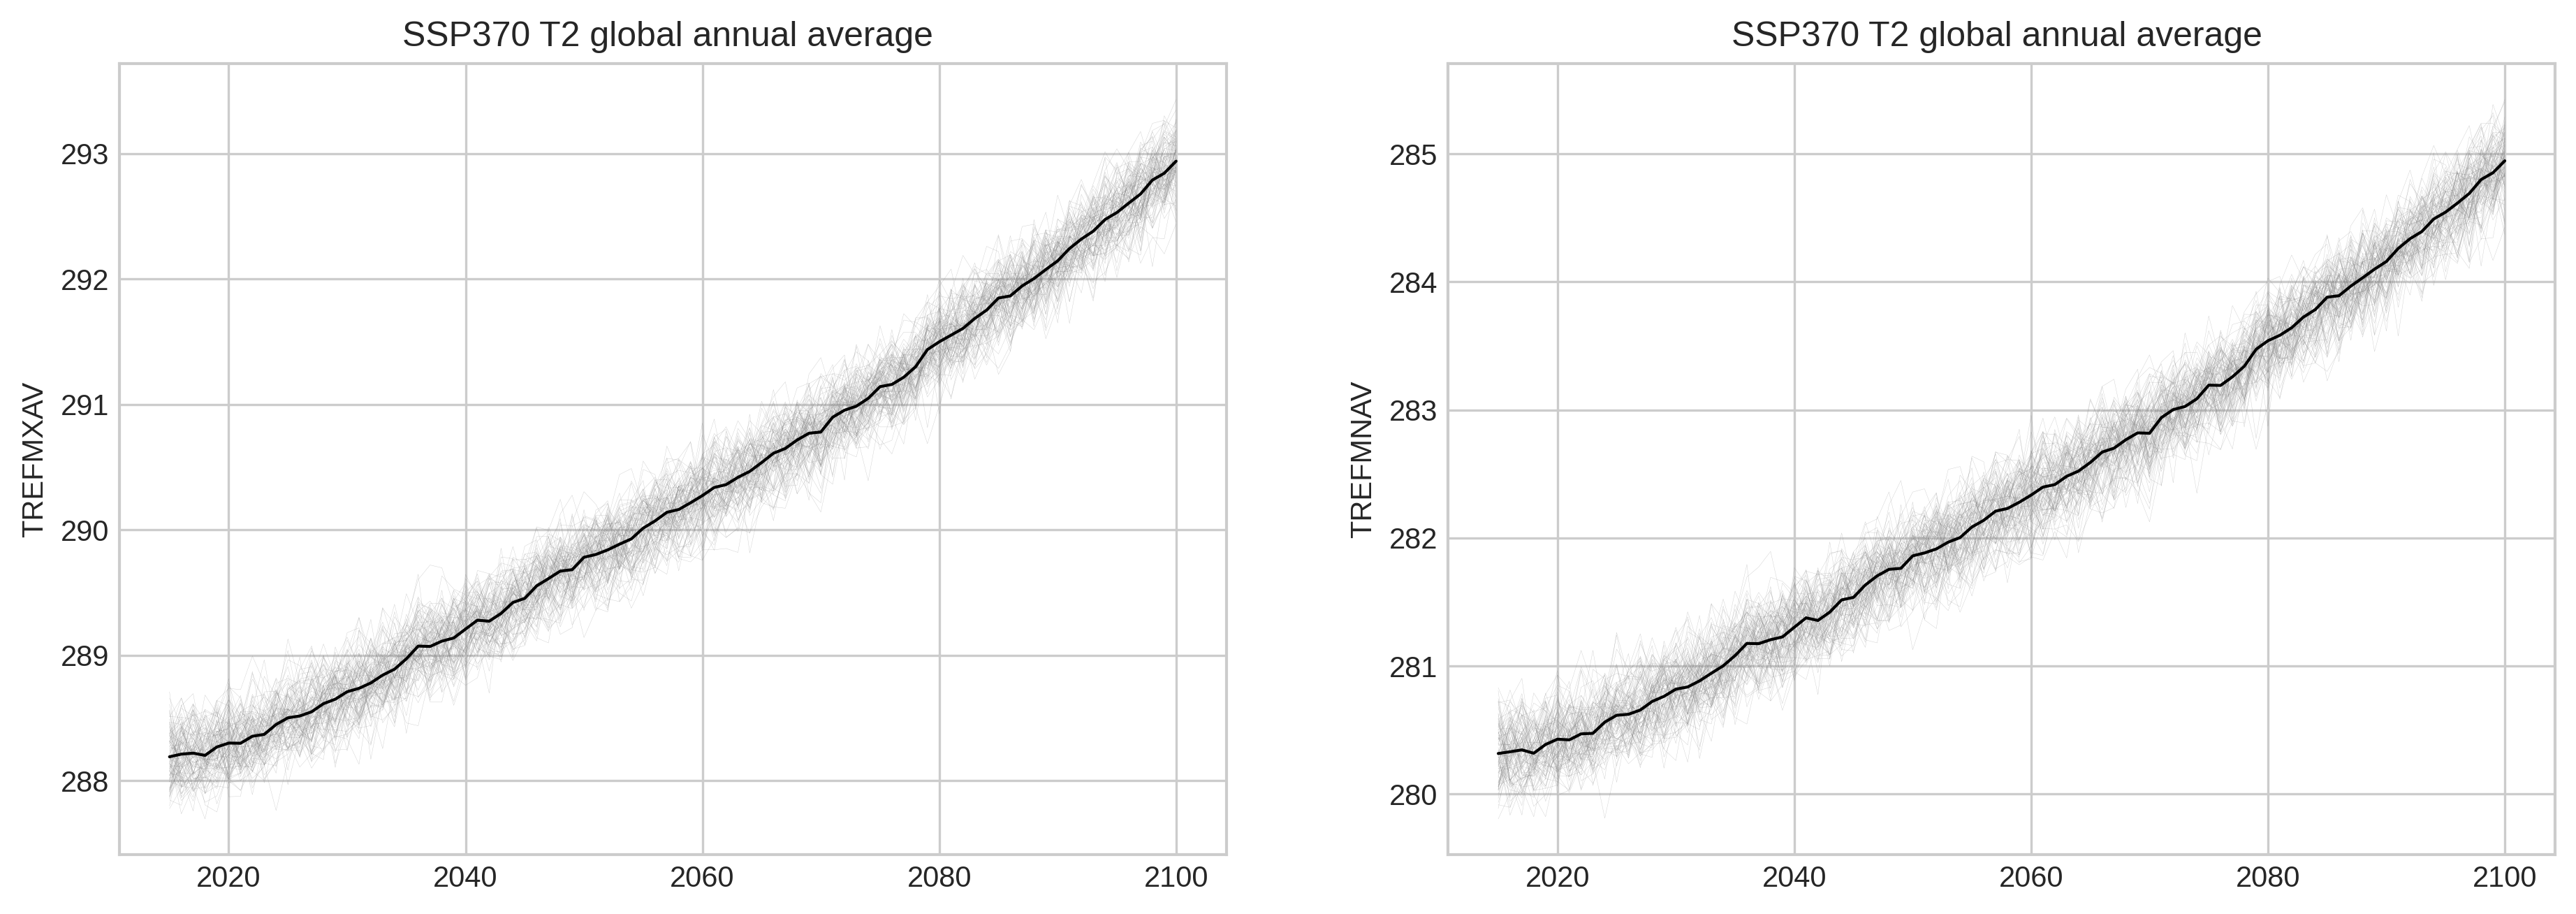

In [6]:
plt.style.use('seaborn-whitegrid')

experiment_1d = ['BHIST', 'SSP370']
n_exp = len(experiment_1d)

for experiment in experiment_1d:
    if experiment == 'SSP370':
        year_s = 2015
        year_e = 2095
    elif experiment == 'BHIST':
        year_s = 1980
        year_e = 2010

    if year_e == 2095:
        ## the last one is 209501-210012 6 years-72 months
        n_month = (year_e - year_s)*12 + 72
        year_ee = year_e + 5
    elif year_e == 2010:
        ## the last one is 201001-201412 5 years-60 months
        n_month = (year_e - year_s)*12 + 60
        year_ee = year_e + 4
    else:
        year_ee = year_e
    
    n_year = int(n_month/12)
    t2_3d = np.zeros((n_var, n_mem, n_month))
    
    nv = 0
    for var_s in var_1d:
        flnm_o = dir_o + var_s+ '_monthly_globalAvg_' + str(year_s) + '01-' + str(year_ee) + '12.nc'
 
        with xr.open_dataset(flnm_o) as ds:
            t2_3d[nv] = ds[var_s]
            nv = nv + 1
            
    t2_4d = t2_3d.reshape((n_var, n_mem, n_year, 12))
    t2_annual_3d = np.mean(t2_4d, axis=3)
     
    # for better resolution, dpi=300, default dpi = 72
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

    for nv in range(n_var):
        for nm in range(n_mem):
            axs[nv].plot(range(year_s, year_ee+1), t2_annual_3d[nv, nm, :], 'grey', linewidth=0.1, alpha=.4)
     
        axs[nv].set_ylabel(var_1d[nv])  
        axs[nv].set_title(experiment + ' T2 global annual average ')    

        axs[nv].plot(range(year_s, year_ee+1),  np.mean(t2_annual_3d[nv, :, :], axis=0), 'black', linewidth=1, alpha=1);        
        

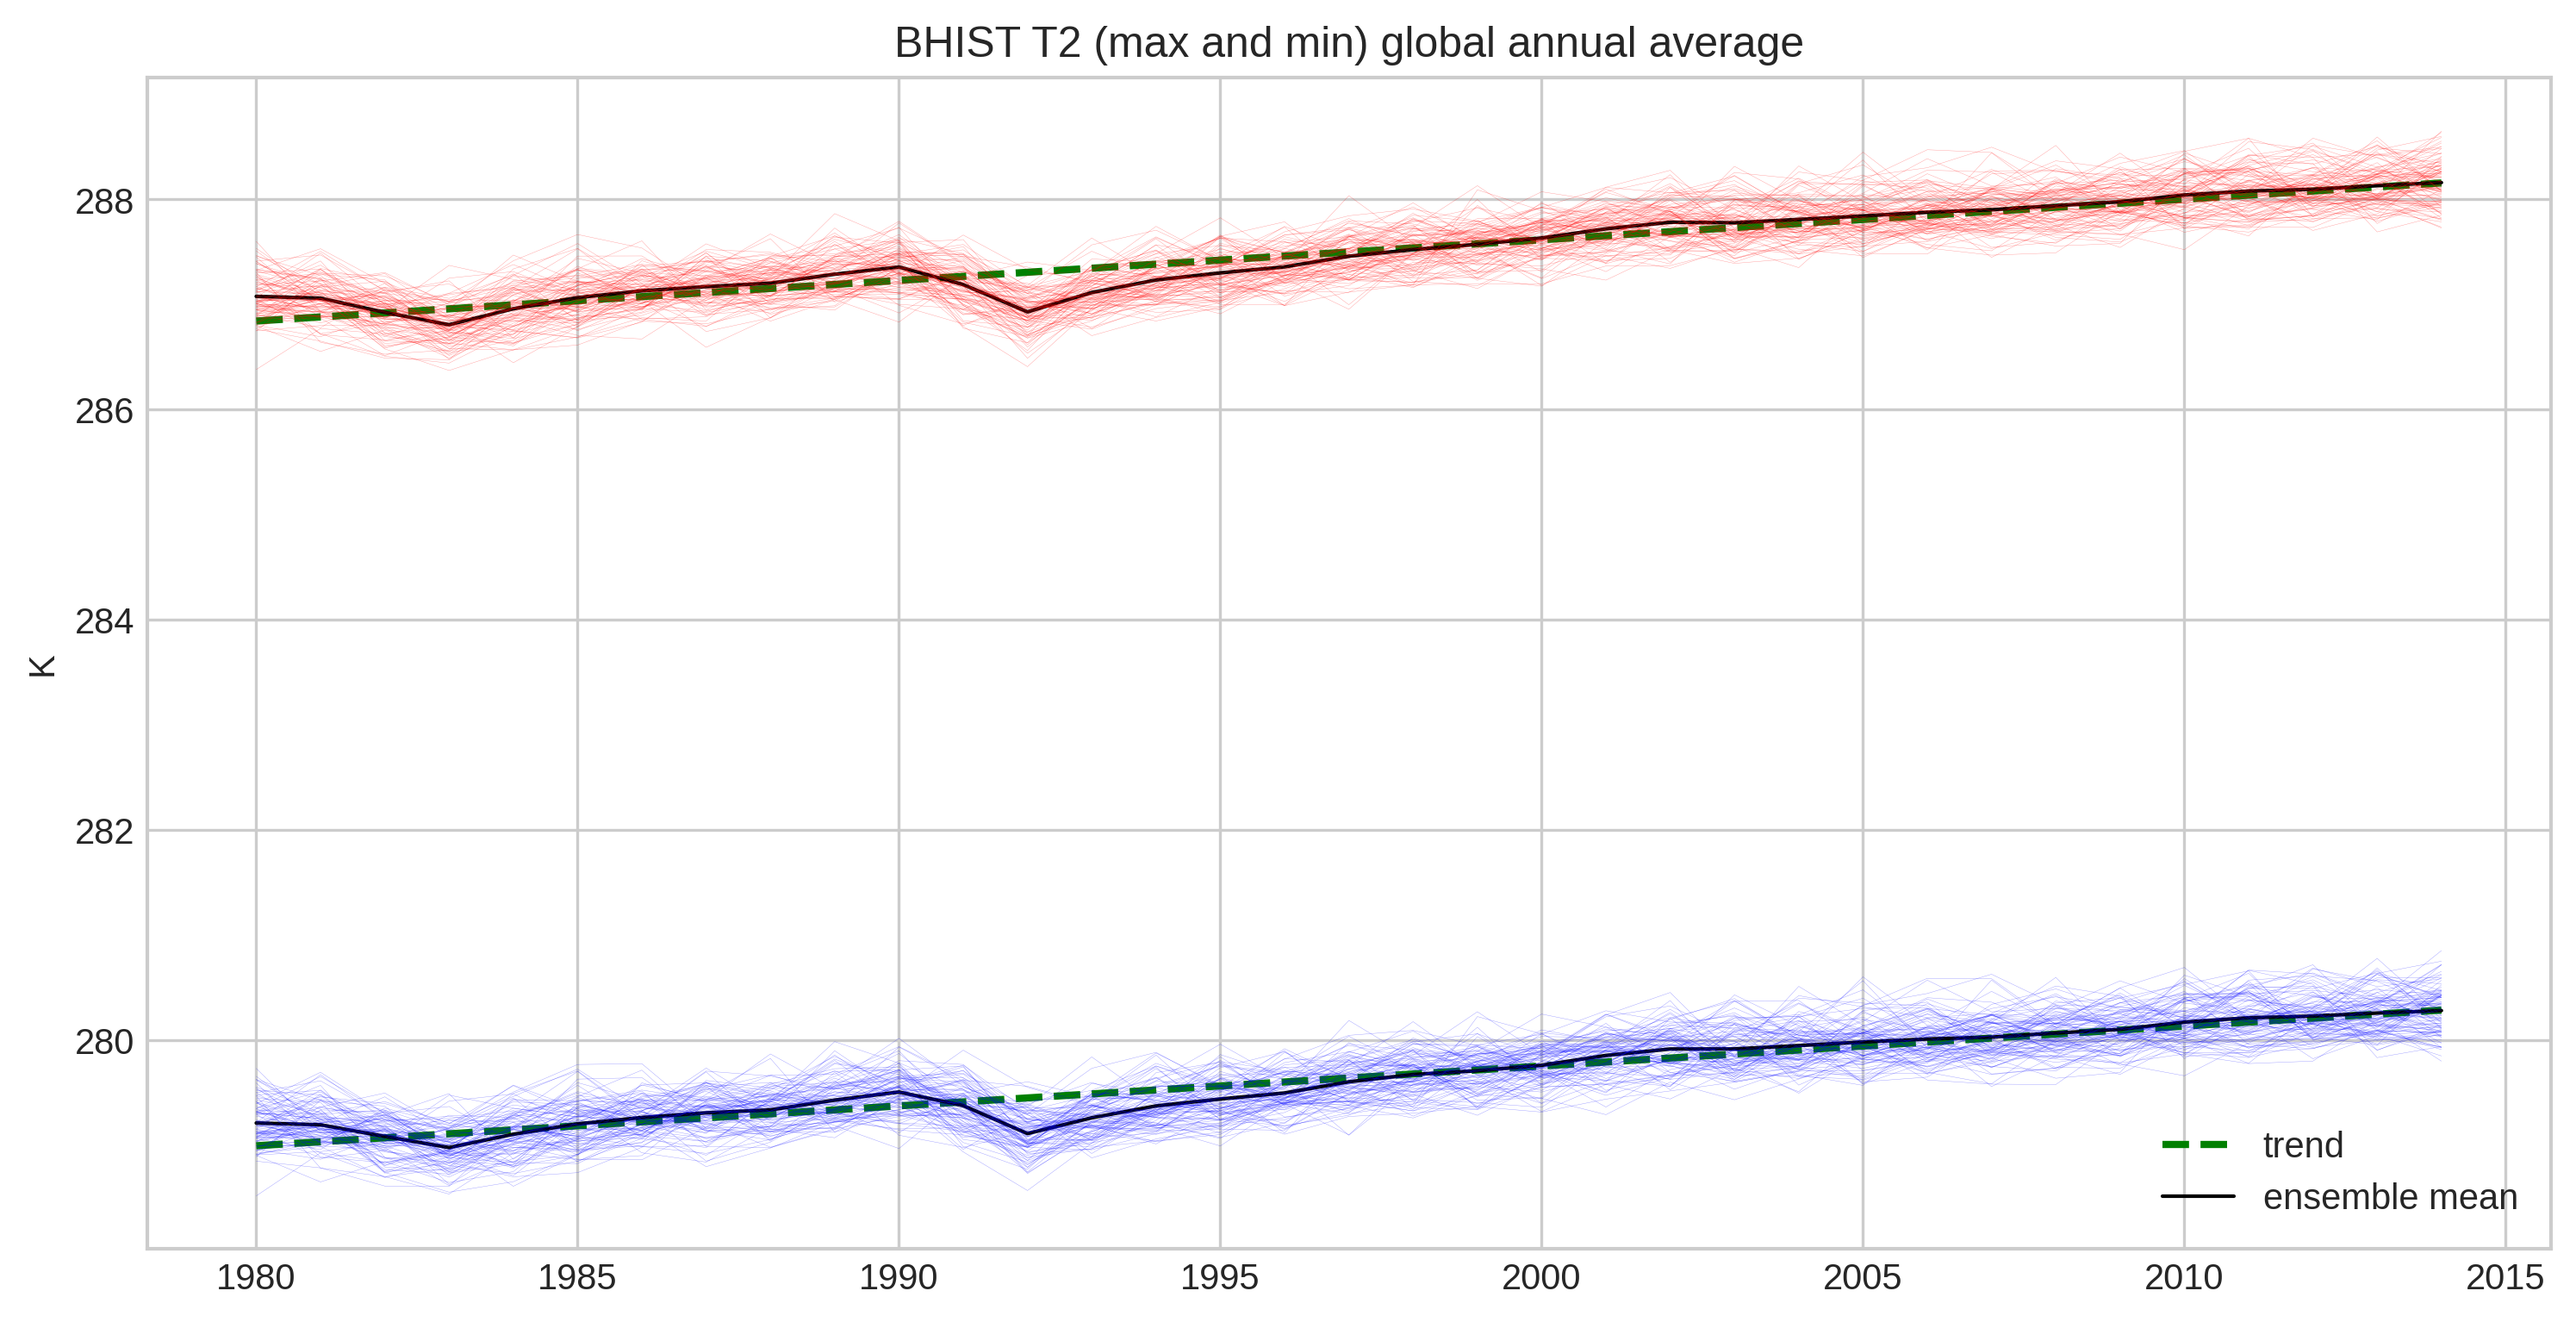

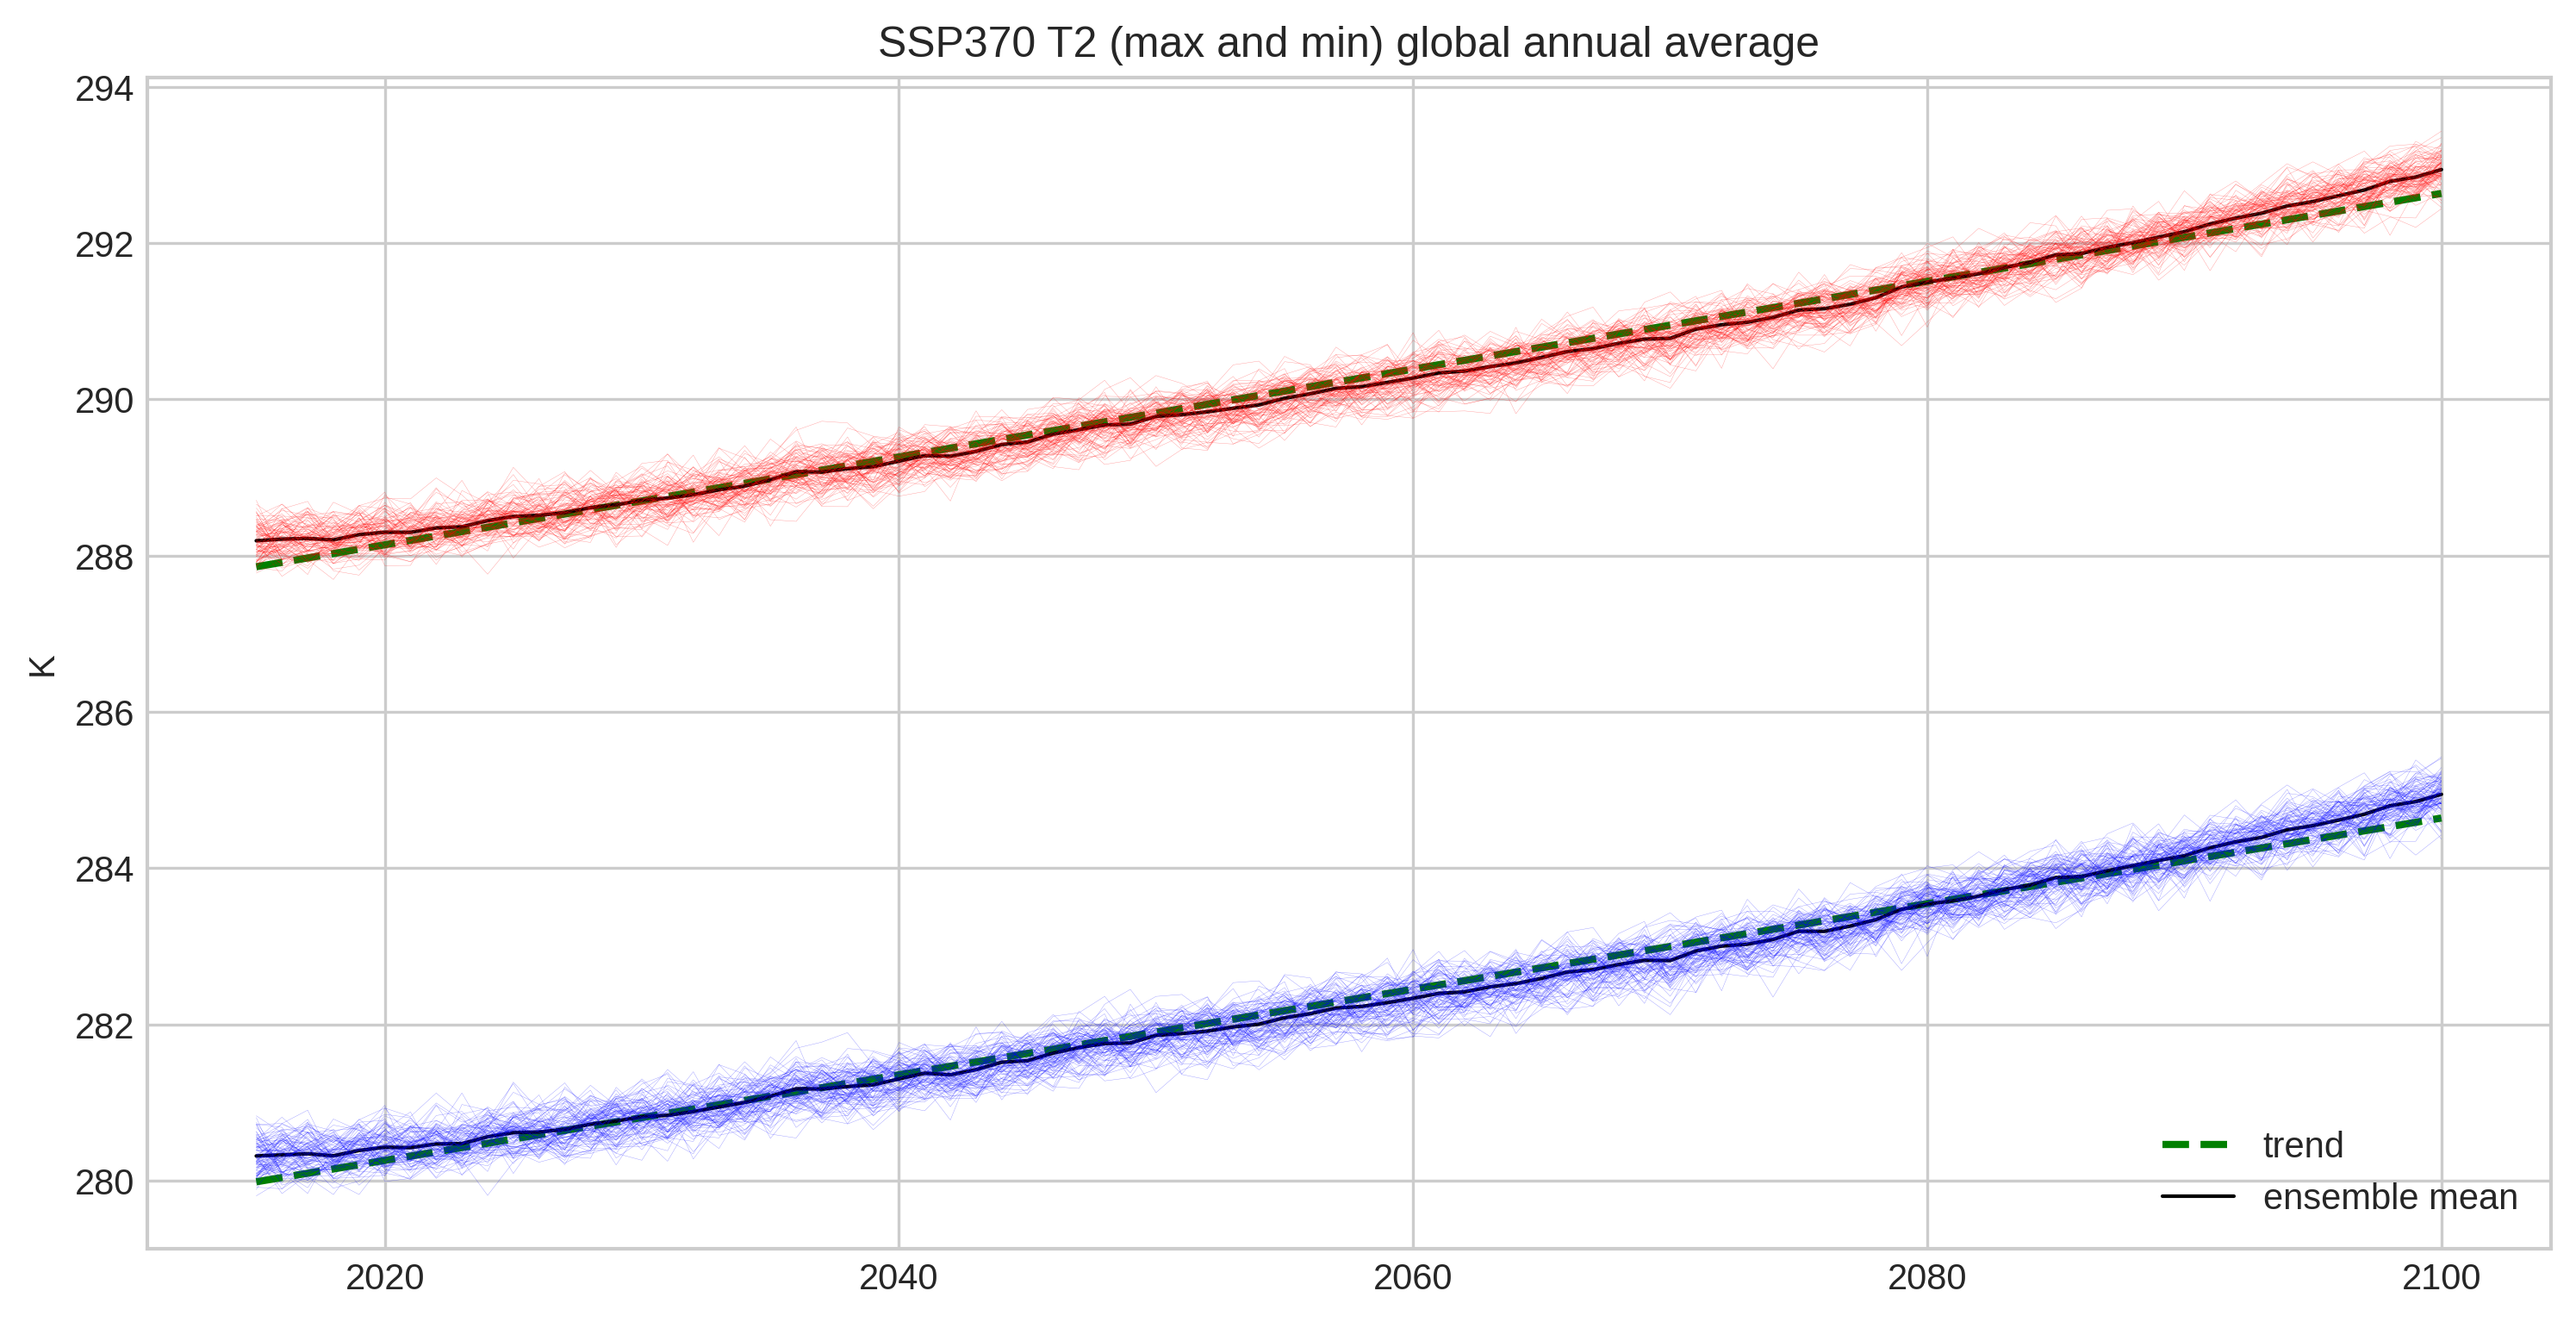

In [8]:
for experiment in experiment_1d:
    if experiment == 'SSP370':
        year_s = 2015
        year_e = 2095
    elif experiment == 'BHIST':
        year_s = 1980
        year_e = 2010

    if year_e == 2095:
        ## the last one is 209501-210012 6 years-72 months
        n_month = (year_e - year_s)*12 + 72
        year_ee = year_e + 5
    elif year_e == 2010:
        ## the last one is 201001-201412 5 years-60 months
        n_month = (year_e - year_s)*12 + 60
        year_ee = year_e + 4
    else:
        year_ee = year_e
    
    n_year = int(n_month/12)
    t2_3d = np.zeros((n_var, n_mem, n_month))
    
    nv = 0
    for var_s in var_1d:
        flnm_o = dir_o + var_s+ '_monthly_globalAvg_' + str(year_s) + '01-' + str(year_ee) + '12.nc'
        #print(flnm_o)
        with xr.open_dataset(flnm_o) as ds:
            t2_3d[nv] = ds[var_s]
            nv = nv + 1
            
    t2_4d = t2_3d.reshape((n_var, n_mem, n_year, 12))
    t2_annual_3d = np.mean(t2_4d, axis=3)
     
    # for better resolution, dpi=300, default dpi = 72
    plt.figure(figsize=(12, 6), dpi=300)

    for nv in range(n_var):
        t2_mean = np.mean(t2_annual_3d[nv, :, :], axis=0)
        # Calculate the Trendline
        z = np.polyfit(range(year_s, year_ee + 1), t2_mean, 1)
        p = np.poly1d(z)
    
        x = range(year_s, year_ee + 1)
        # Display the Trendline
        plt.plot(range(year_s, year_ee +1), p(x), 'green', linewidth=2, alpha=1, linestyle='dashed')
    
        plt.plot(range(year_s, year_ee + 1), t2_mean, 'black', linewidth=1, alpha=1)
        for nm in range(n_mem):
            if nv == 0:
                plt.plot(range(year_s, year_ee + 1),  t2_annual_3d[nv, nm, :], 'r', linewidth=.1, alpha=0.4)
            else:
                plt.plot(range(year_s, year_ee + 1),  t2_annual_3d[nv, nm, :], 'b', linewidth=.1, alpha=0.4)

    # Function add a legend  
    plt.legend(["trend", "ensemble mean"], loc ="lower right")
    plt.ylabel('K')
    plt.title(experiment + ' T2 (max and min) global annual average');  
         